# Butterfly Detection

Importing libraries

In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import cv2
from PIL import Image
import tensorflow as tf
import keras
import numpy as np
from tqdm import tqdm
import pandas as pd
import random 
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, AveragePooling2D, PReLU,Input, add,AveragePooling2D,ZeroPadding2D
from keras.layers.merge import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.initializers import Constant
from keras.models import load_model
from sklearn.model_selection import cross_val_score

Setting random seeds for reproducability

In [2]:
np.random.seed(123)
random.seed(234) # setting random seeds . doesnt really work due to deteministic cudnn library
tf.random.set_seed(345)

Some code for GPU compatibility

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

To use mixed precission for faster training

In [4]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')              # TO USE TENSOR CORES
mixed_precision.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2060, compute capability 7.5


Data Generators

In [5]:
datagen=ImageDataGenerator(rescale=1./255,                    
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                rotation_range=90,
                                zoom_range=0.2,
                                fill_mode='nearest',
                                shear_range=0.2,
                                 horizontal_flip=True
                                )
val_datagen=ImageDataGenerator(rescale=1./255)

test_datagen=ImageDataGenerator(rescale=1./255)

Making and Saving augmented images for using the same ones every time

In [ ]:
count=0
if not os.path.exists('train'):
    os.mkdir('train')
if not os.path.exists('val'):
    os.mkdir('val')
if not os.path.exists('train-aug'):
    os.mkdir('train-aug')
for i in tqdm(os.listdir('DATA/TRAIN')):
    sub_path='DATA/TRAIN/'+i+'/'
    os.mkdir('train/'+i)
    os.mkdir('val/'+i)
    os.mkdir('train-aug/'+i)
    imgs=os.listdir(sub_path)
    num=round(len(imgs)*0.1)
    val_images=random.sample(imgs,num)
    train_images=[item for item in imgs if item not in val_images]
    for j in train_images:
        img=Image.open(sub_path+j)
        img=img.convert("RGB")
        img.save('train/'+i+'/'+j)
        img=load_img(sub_path+j)
        img=img_to_array(img)
        img=img[:,:,:3]
        #print(img.shape)
        img=img.reshape((1,)+img.shape)
        i_=0
        for batch in datagen.flow(img,batch_size=1,save_to_dir='train-aug/'+i,save_format='jpeg'):
            count+=1
            i_+=1
            if i_==5:
                break
    for j in val_images:
        img=Image.open(sub_path+j)
        img=img.convert("RGB")
        img.save('val/'+i+'/'+j)

In [7]:
X=[]
y=[]
for i in tqdm(os.listdir('DATA/TRAIN')):
    sub_path='DATA/TRAIN/'+i+'/'
    for img in os.listdir(sub_path):
        img_path=sub_path+img
        im=Image.open(img_path)
        im=im.convert("RGB")
        im=im.resize((224,224))
        im=np.asarray(im)
        X.append(im)
        y.append(i)
X=np.asarray(X)
y=np.asarray(y)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:43<00:00,  1.16it/s]


In [8]:
X_test=[]

for i in tqdm(os.listdir('DATA/TEST2')):
    sub_path='DATA/TEST2/'+i+'/'
    for img in os.listdir(sub_path):
        img_path=sub_path+img
        im=Image.open(img_path)
        im=im.convert("RGB")
        im=im.resize((224,224))
        pixels=np.array(im)
        X_test.append(pixels)
X_test=np.asarray(X_test)        

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


In [9]:
X_train=[]
y_train=[]
for i in tqdm(os.listdir('train/')):
    sub_path='train/'+i+'/'
    for img in os.listdir(sub_path):
        img_path=sub_path+img
        im=Image.open(img_path)
        im=im.convert("RGB")
        im=im.resize((224,224))
        im=np.asarray(im)
        X_train.append(im)
        y_train.append(i)
X_train=np.asarray(X_train)
y_train=np.asarray(y_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.52it/s]


In [10]:
X_train_aug=[]
y_train_aug=[]
for i in tqdm(os.listdir('train-aug/')):
    sub_path='train-aug/'+i+'/'
    for img in os.listdir(sub_path):
        img_path=sub_path+img
        im=Image.open(img_path)
        im=im.convert("RGB")
        im=im.resize((224,224))
        im=np.asarray(im)
        X_train_aug.append(im)
        y_train_aug.append(i)
X_train_aug=np.asarray(X_train_aug)
y_train_aug=np.asarray(y_train_aug)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.25s/it]


In [11]:
X_val=[]
y_val=[]
for i in tqdm(os.listdir('val/')):
    sub_path='val/'+i+'/'
    for img in os.listdir(sub_path):
        img_path=sub_path+img
        im=Image.open(img_path)
        im=im.convert("RGB")
        im=im.resize((224,224))
        im=np.asarray(im)
        X_val.append(im)
        y_val.append(i)
X_val=np.asarray(X_val)
y_val=np.asarray(y_val)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.58it/s]


In [12]:
print(X.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_train_aug.shape)
print(y_train_aug.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)

(4479, 224, 224, 3)
(4479,)
(4035, 224, 224, 3)
(4035,)
(19750, 224, 224, 3)
(19750,)
(444, 224, 224, 3)
(444,)
(500, 224, 224, 3)


Converting names to numbers then converting it to a one hot encoding

In [13]:
enc=LabelEncoder()
y=enc.fit_transform(y)
y_train=enc.transform(y_train)
y_train_aug=enc.transform(y_train_aug)
y_val=enc.transform(y_val)
y_c=to_categorical(y)
y_trainc=to_categorical(y_train)
y_train_augc=to_categorical(y_train_aug)
y_valc=to_categorical(y_val)

In [14]:
print(X.shape)
print(y.shape)
print(X_train.shape)
print(y_trainc.shape)
print(X_train_aug.shape)
print(y_train_augc.shape)
print(X_val.shape)
print(y_valc.shape)
print(X_test.shape)

(4479, 224, 224, 3)
(4479,)
(4035, 224, 224, 3)
(4035, 50)
(19750, 224, 224, 3)
(19750, 50)
(444, 224, 224, 3)
(444, 50)
(500, 224, 224, 3)


# model 1 : (C-M)x2 (C-M-B-D)x2 5xD

In [15]:
cnn1 = Sequential()           #cnn structure 2X CMD - 2XCMBD - 5XDense
cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3)))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))


cnn1.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))


cnn1.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(BatchNormalization())
cnn1.add(Dropout(0.2))

cnn1.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(BatchNormalization())
cnn1.add(Dropout(0.2))

cnn1.add(Conv2D(512, kernel_size=(2,2), activation='relu'))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(BatchNormalization())
cnn1.add(Dropout(0.2))

cnn1.add(Flatten())

cnn1.add(Dense(1024, activation='relu'))
cnn1.add(Dense(512, activation='relu'))
cnn1.add(Dropout(0.2))
cnn1.add(Dense(256, activation='relu'))
cnn1.add(Dropout(0.2))
cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(50, activation='softmax'))

cnn1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

cnn1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 128)       5

In [16]:
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

history1= cnn1.fit(X_train_aug,y_train_augc,validation_data=(X_val,y_valc),callbacks=[reduce_lr_loss,early_stopping],epochs=10)

Epoch 1/10
618/618 [==============================] - 42s 68ms/step - loss: 3.1572 - accuracy: 0.1600 - val_loss: 2.6242 - val_accuracy: 0.2162
Epoch 2/10
618/618 [==============================] - 41s 66ms/step - loss: 2.2744 - accuracy: 0.3318 - val_loss: 2.5242 - val_accuracy: 0.3468
Epoch 3/10
618/618 [==============================] - 41s 66ms/step - loss: 1.8359 - accuracy: 0.4472 - val_loss: 1.9951 - val_accuracy: 0.4414
Epoch 4/10
618/618 [==============================] - 41s 67ms/step - loss: 1.4991 - accuracy: 0.5477 - val_loss: 1.4098 - val_accuracy: 0.6059
Epoch 5/10
618/618 [==============================] - 43s 69ms/step - loss: 1.2089 - accuracy: 0.6256 - val_loss: 1.3572 - val_accuracy: 0.6239
Epoch 6/10
618/618 [==============================] - 43s 69ms/step - loss: 0.9793 - accuracy: 0.6981 - val_loss: 1.2581 - val_accuracy: 0.6689
Epoch 7/10
618/618 [==============================] - 43s 69ms/step - loss: 0.8027 - accuracy: 0.7464 - val_loss: 1.0951 - val_accuracy:

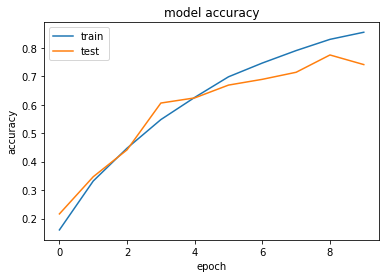

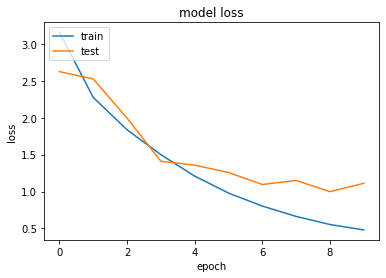

In [17]:
import matplotlib.pyplot as plt             # plot loss and accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
y_predv=cnn1.predict(X_val)
y_predv=np.argmax(y_predv,axis=1)
#y_vo=np.argmax(y_val,axis=1)
print(accuracy_score(y_val,y_predv))

0.740990990990991


In [19]:
y_pred1=cnn1.predict(X_test)
y_pred1=np.argmax(y_pred1,axis=1)
y_pred1=enc.inverse_transform(y_pred1)

In [20]:
test_img=os.listdir('DATA/TEST2/TEST')

In [21]:
submission=pd.DataFrame(columns=['Filename','Labels'])
submission['Filename']=test_img
submission['Labels']=y_pred1

In [22]:
submission.to_csv('s_4c5d-aug.csv',index=None)

# model 2 : (C-C-M)x2 (C-C-M-B) (C-M-B-D)x3 5xD

In [23]:
cnn2 = Sequential()           #cnn structure 2X CMD - 2XCMBD - 5XDense
cnn2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3)))
cnn2.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2)))


cnn2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2)))


cnn2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(BatchNormalization())

cnn2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(BatchNormalization())

cnn2.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(BatchNormalization())
cnn2.add(Dropout(0.2))

cnn2.add(Conv2D(512, kernel_size=(2,2), activation='relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(BatchNormalization())
cnn2.add(Dropout(0.2))

#cnn2.add(Conv2D(1024, kernel_size=(2,2), activation='relu'))
#cnn2.add(MaxPooling2D(pool_size=(2, 2)))
#cnn2.add(BatchNormalization())
#cnn2.add(Dropout(0.2))

cnn2.add(Flatten())

cnn2.add(Dense(1024, activation='relu'))
cnn2.add(Dense(512, activation='relu'))
cnn2.add(Dropout(0.33))
cnn2.add(Dense(256, activation='relu'))
cnn2.add(Dropout(0.33))
cnn2.add(Dense(128, activation='relu'))
cnn2.add(Dense(50, activation='softmax'))

cnn2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])



cnn2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 51, 51, 128)      

In [24]:
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
early_stopping = EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)

history1= cnn2.fit(X_train_aug,y_train_augc,batch_size=32,validation_data=(X_val,y_valc),callbacks=[reduce_lr_loss,early_stopping],epochs=10)

Epoch 1/10
618/618 [==============================] - 63s 101ms/step - loss: 3.6970 - accuracy: 0.0626 - val_loss: 3.5925 - val_accuracy: 0.0743
Epoch 2/10
618/618 [==============================] - 62s 101ms/step - loss: 3.1105 - accuracy: 0.1397 - val_loss: 3.7666 - val_accuracy: 0.0878
Epoch 3/10
618/618 [==============================] - 63s 103ms/step - loss: 2.6591 - accuracy: 0.2283 - val_loss: 3.0554 - val_accuracy: 0.1802
Epoch 4/10
618/618 [==============================] - 64s 103ms/step - loss: 2.3529 - accuracy: 0.2985 - val_loss: 2.9121 - val_accuracy: 0.2230
Epoch 5/10
618/618 [==============================] - 64s 103ms/step - loss: 2.1392 - accuracy: 0.3609 - val_loss: 2.8466 - val_accuracy: 0.2477
Epoch 6/10
618/618 [==============================] - 64s 103ms/step - loss: 1.9543 - accuracy: 0.4085 - val_loss: 1.8644 - val_accuracy: 0.4550
Epoch 7/10
618/618 [==============================] - 64s 103ms/step - loss: 1.8119 - accuracy: 0.4467 - val_loss: 2.4117 - val_ac

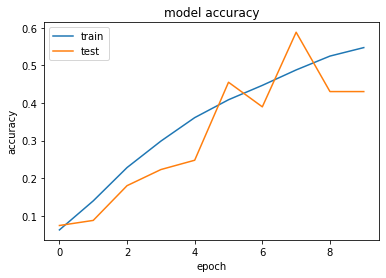

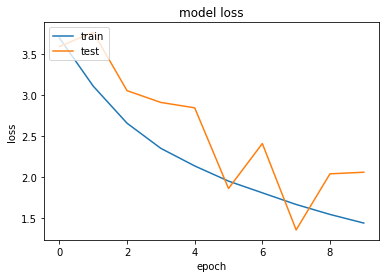

In [25]:
import matplotlib.pyplot as plt             # plot loss and accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
y_pred=cnn2.predict(X_val)
y_pred=np.argmax(y_pred,axis=1)
print(accuracy_score(y_val,y_pred))

0.43018018018018017


In [27]:
submission=pd.DataFrame(columns=['Filename','Labels'])
y_pred2=cnn2.predict(X_test)
y_pred2=np.argmax(y_pred2,axis=1)
y_pred2=enc.inverse_transform(y_pred2)
submission['Filename']=test_img
submission['Labels']=y_pred2
submission.to_csv('6c5d-aug2.csv',index=None)

# cnn2 with SVM

In [28]:
cnn3=cnn2.layers[:-7]
cnn3=Sequential(cnn3)
cnn3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 51, 51, 128)      

In [29]:
for layer in cnn3.layers:
    layer.trainable=False

In [30]:
X_ei=[]
for i in os.listdir('DATA/TRAIN'):
    sub_path='DATA/TRAIN/'+i+'/'
    for img in os.listdir(sub_path):
        img_path=sub_path+img
        im=Image.open(img_path)
        im=im.convert("RGB")
        im=im.resize((224,224))
        im=np.asarray(im)
        X_ei.append(im)

In [31]:
X_ei_a=[]
for i in tqdm(os.listdir('train-aug/')):
    sub_path='train-aug/'+i+'/'
    for img in os.listdir(sub_path):
        img_path=sub_path+img
        im=Image.open(img_path)
        im=im.convert("RGB")
        im=im.resize((224,224))
        im=np.asarray(im)
        X_ei_a.append(im)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:42<00:00,  3.25s/it]


In [32]:
def get_embed(X):
    count=0
    X_=[] 
    for image in tqdm(X):
        image=np.expand_dims(image,axis=0)
        X_embed=cnn3.predict([image])
        X_embed=X_embed.reshape(512,)
        X_.append(X_embed)
        count+=1
        #print(count)
    return np.asarray(X_)

In [33]:
X_train_e_a=get_embed(X_ei_a)

100%|████████████████████████████████████████████████████████████████████████████| 19750/19750 [11:12<00:00, 29.37it/s]


In [34]:
X_train_e_a.shape

(19750, 512)

In [35]:
X_tei=[]

for i in tqdm(os.listdir('DATA/TEST2')):
    sub_path='DATA/TEST2/'+i+'/'
    for img in os.listdir(sub_path):
        img_path=sub_path+img
        im=Image.open(img_path)
        im=im.convert("RGB")
        im=im.resize((224,224))
        pixels=np.array(im)
        X_tei.append(pixels)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


In [36]:
X_test_ei=get_embed(X_tei)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:17<00:00, 29.28it/s]


In [37]:
svm=SVC(kernel='linear')
X_tre,X_ve,y_tre,y_ve=train_test_split(X_train_e_a,y_train_aug,test_size=0.033)

In [38]:
svm.fit(X_tre,y_tre)
y_prev=svm.predict(X_ve)
print(accuracy_score(y_ve,y_prev))

0.7162576687116564


In [39]:
y_pred3=svm.predict(X_test_ei)
y_pred3=enc.inverse_transform(y_pred3)
submission['Filename']=test_img
submission['Labels']=y_pred3
submission.to_csv('5c4d-svm-aug.csv',index=None)

In [40]:
submission

,Filename,Labels
0,000.jpg,red admiral
1,001.jpg,straited queen
2,002.jpg,metalmark
3,003.jpg,pipevine swallow
4,004.jpg,scarce swallow
...,...,...
495,495.jpg,american snoot
496,496.jpg,red spotted purple
497,497.jpg,paper kite
498,498.jpg,pine white


# model 4

In [41]:
cnn3 = Sequential()           #cnn structure 2X CMD - 2XCMBD - 5XDense
cnn3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3)))
cnn3.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))


cnn3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))


cnn3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))
cnn3.add(BatchNormalization())


cnn3.add(Conv2D(256, kernel_size=(2,2), activation='relu'))
cnn3.add(Conv2D(256, kernel_size=(2,2), activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))
cnn3.add(BatchNormalization())
cnn3.add(Dropout(0.2))

cnn3.add(Conv2D(512, kernel_size=(2,2), activation='relu'))
cnn3.add(Conv2D(512, kernel_size=(2,2), activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))
cnn3.add(BatchNormalization())
cnn3.add(Dropout(0.2))

cnn3.add(Conv2D(1024, kernel_size=(2,2), activation='relu'))
cnn3.add(Conv2D(1024, kernel_size=(2,2), activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))
cnn3.add(BatchNormalization())
cnn3.add(Dropout(0.2))

cnn3.add(Flatten())

cnn3.add(Dense(1024, activation='relu'))
cnn3.add(Dense(512, activation='relu'))
cnn3.add(Dropout(0.33))
cnn3.add(Dense(256, activation='relu'))
cnn3.add(Dropout(0.33))
cnn3.add(Dense(128, activation='relu'))
cnn3.add(Dense(50, activation='softmax'))

cnn3.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

cnn3.compile(
    loss='categorical_crossentropy',
    optimizer='SGD',
    metrics=['accuracy']
)

cnn3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 220, 220, 32)      9248      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 218, 218, 64)      18496     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 216, 216, 64)      36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 108, 108, 64)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 106, 106, 128)     73856     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 104, 104, 128)    

In [ ]:
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
early_stopping = EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)

history1= cnn3.fit(X_train_aug,y_train_augc,validation_data=(X_val,y_valc),callbacks=[reduce_lr_loss,early_stopping],epochs=10)

# xception

In [ ]:
from keras.applications import Xception
pretrained=Xception(weights='imagenet',include_top=False,input_shape=(224,224,3))
for layer in pretrained.layers[:-15]:
    layer.trainable=False
pretrained.summary()

In [ ]:
cnn4=Sequential()
cnn4.add(pretrained)
cnn4.add(Flatten())
cnn4.add(Dense(units=1024,activation="relu"))
cnn4.add(Dropout(0.2))
cnn4.add(Dense(units=64,activation='relu'))
cnn4.add(Dense(units=50,activation='softmax'))

cnn4.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

cnn4.summary()

In [ ]:
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
early_stopping = EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)

history1= cnn4.fit(X_train,y_train,validation_data=(X_val,y_val),callbacks=[reduce_lr_loss,early_stopping],epochs=100)

In [ ]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

# model 5 inception

In [ ]:
X_i=[]
y_i=[]
for i in tqdm(os.listdir('DATA/TRAIN')):
    sub_path='DATA/TRAIN/'+i+'/'
    for img in os.listdir(sub_path):
        img_path=sub_path+img
        im=Image.open(img_path)
        im=im.convert("RGB")
        im=im.resize((92,92))
        im=np.asarray(im)
        X_i.append(im)
        y_i.append(i)
X_incep=np.asarray(X)
y_incep=np.asarray(y)

In [ ]:
X_test_i=[]

for i in tqdm(os.listdir('DATA/TEST2')):
    sub_path='DATA/TEST2/'+i+'/'
    for img in os.listdir(sub_path):
        img_path=sub_path+img
        im=Image.open(img_path)
        im=im.convert("RGB")
        im=im.resize((92,92))
        pixels=np.array(im)
        X_test_i.append(pixels)
X_test_incep=np.asarray(X_test_i)        

In [ ]:
def make_inception(x,n1_in,n1_out,n2_in,n2_out,n3_out,n4_out):
    
    conv3=Conv2D(filters=n1_in,kernel_size=(1,1),padding='same',kernel_initializer='random_uniform')(x)
    conv3=Conv2D(filters=n2_out,kernel_size=(3,3),padding='same',kernel_initializer='random_uniform')(conv3)
    
    conv5=Conv2D(filters=n2_in,kernel_size=(1,1),padding='same',kernel_initializer='random_uniform')(x)
    conv5=Conv2D(filters=n2_out,kernel_size=(5,5),padding='same',kernel_initializer='random_uniform')(conv5)
    
    #conv7=Conv2D(filters=n3_in,kernel_size=(1,1),padding='same',kernel_initializer='random_uniform')(x)
    #conv7=Conv2D(filters=n3_out,kernel_size=(7,7),padding='same',kernel_initializer='random_uniform')(conv7)
    
    pool=MaxPooling2D((3,3),padding='same',strides=(1,1))(x)
    pool=Conv2D(filters=n3_out,kernel_size=(1,1),kernel_initializer='random_uniform')(pool)
    
    conv1=Conv2D(filters=n4_out,padding='same',kernel_initializer='random_uniform',kernel_size=(1,1))(x)
    
    out=concatenate([conv3,conv5,conv1,pool],axis=-1)
    
    return out
    
    

In [ ]:
inp=Input(shape=(92,92,3))
#layer=Conv2D(32,(3,3),activation='relu')
layer=make_inception(inp,64,64,64,64,64,64)
layer=make_inception(layer,128,128,128,128,128,128)
layer=Flatten()(layer)
out=Dense(units=50,activation='softmax')(layer)
model_incep=Model(inputs=inp,outputs=out)

In [ ]:
model_incep.summary()

In [ ]:
model_incep.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

history1= model_incep.fit(X_incep,y_c,validation_split=0.1,callbacks=[reduce_lr_loss,early_stopping],epochs=100)

# model 6 resnet

In [42]:
def make_res(x,n):
    inp=x
    if (x.shape[-1]!=n):
        inp=Conv2D(filters=n,kernel_size=(1,1),padding='same',kernel_initializer='random_uniform',activation='relu')(x)
    conv3=Conv2D(filters=n,kernel_size=(3,3),padding='same',kernel_initializer='random_uniform',activation='relu')(x)
    conv3=Conv2D(filters=n,kernel_size=(3,3),padding='same',kernel_initializer='random_uniform',activation='relu')(conv3)
    layer=add([inp,conv3])
    out=MaxPooling2D(pool_size=(2, 2))(layer)
    return out

In [43]:
inp = Input(shape=(224,224,3))           #cnn structure 2X CMD - 2XCMBD - 5XDense
layer=Conv2D(32, kernel_size=(3, 3), activation='relu')(inp)
layer=Conv2D(32, kernel_size=(3, 3), activation='relu')(layer)


layer=make_res(layer,64)


layer=make_res(layer,128)
layer=BatchNormalization()(layer)


layer=make_res(layer,256)
layer=BatchNormalization()(layer)
layer=Dropout(0.2)(layer)

layer=make_res(layer,512)
layer=BatchNormalization()(layer)
layer=Dropout(0.2)(layer)


layer=make_res(layer,1024)
layer=BatchNormalization()(layer)
layer=Dropout(0.2)(layer)

layer=Flatten()(layer)

layer=Dense(1024, activation='relu')(layer)
layer=Dense(512, activation='relu')(layer)
layer=Dropout(0.33)(layer)
layer=Dense(256, activation='relu')(layer)
layer=Dropout(0.33)(layer)
layer=Dense(128, activation='relu')(layer)
layer=Dense(50, activation='softmax')(layer)

res_model=Model(inputs=inp,outputs=layer)

res_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])


res_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 222, 222, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 220, 220, 32) 9248        conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 220, 220, 64) 18496       conv2d_28[0][0]                  
_______________________________________________________________________________________

In [45]:
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

history1= res_model.fit(X_train_aug,y_train_augc,validation_data=(X_val,y_valc),callbacks=[reduce_lr_loss],epochs=3)

Epoch 1/3
618/618 [==============================] - 228s 369ms/step - loss: 3.6382 - accuracy: 0.0749 - val_loss: 3.3256 - val_accuracy: 0.0968
Epoch 2/3
618/618 [==============================] - 228s 369ms/step - loss: 3.1080 - accuracy: 0.1471 - val_loss: 4.2779 - val_accuracy: 0.0653
Epoch 3/3
618/618 [==============================] - 229s 370ms/step - loss: 2.6758 - accuracy: 0.2292 - val_loss: 2.3891 - val_accuracy: 0.3018


In [46]:
submission=pd.DataFrame(columns=['Filename','Labels'])
y_pred4=res_model.predict(X_test)
y_pred4=np.argmax(y_pred4,axis=1)
y_pred4=enc.inverse_transform(y_pred4)
submission['Filename']=test_img
submission['Labels']=y_pred4
submission.to_csv('diy-resnet-aug.csv',index=None)

In [47]:
y_predv=res_model.predict(X_val)
print(y_predv.shape)
y_predv=np.argmax(y_predv,axis=1)
print(accuracy_score(y_val,y_predv))

(444, 50)
0.30180180180180183


# resnet 2 

In [51]:
def res_block(X,f):
    f1,f2,f3=f
    X_skip=X
    
    X=Conv2D(f1,(1,1),padding='valid')(X)
    X=BatchNormalization(axis=3)(X)
    X=Activation('relu')(X)
    
    X=Conv2D(f2,(3,3),padding='same')(X)
    X=BatchNormalization(axis=3)(X)
    X=Activation('relu')(X)
    
    X=Conv2D(f3,(1,1),padding='valid')(X)
    X=BatchNormalization(axis=3)(X)

    
    X_skip=Conv2D(f3,(1,1),padding='valid')(X_skip)
    X_skip=BatchNormalization(axis=3)(X_skip)
    
    X=add([X_skip,X])
    X=Activation('relu')(X)
    
    
    return X    

In [52]:
def conv_block(X,f,s):
    f1,f2,f3=f
    X_skip=X
    
    X=Conv2D(f1,(1,1),padding='valid',strides=(s,s))(X)
    X=BatchNormalization(axis=3)(X)
    X=Activation('relu')(X)
    
    X=Conv2D(f2,(3,3),padding='same')(X)
    X=BatchNormalization(axis=3)(X)
    X=Activation('relu')(X)
    
    X=Conv2D(f3,(1,1),padding='valid')(X)
    X=BatchNormalization(axis=3)(X)

    
    X_skip=Conv2D(f3,(1,1),padding='valid',strides=(s,s))(X_skip)
    X_skip=BatchNormalization(axis=3)(X_skip)
    
    X=add([X_skip,X])
    X=Activation('relu')(X)
    
    
    return X    

In [53]:
def model_res(input_shape=(224,224,3),classes=50):
    X_inp=Input(input_shape)
    
    X=ZeroPadding2D((3,3))(X_inp)
    
    X=Conv2D(64,(7,7),strides=(2,2))(X)
    X=BatchNormalization(axis=3)(X)
    X=Activation('relu')(X)
    X=MaxPooling2D((3,3),strides=(2,2))(X)
    
    X=conv_block(X,[64,64,256],1)
    X=res_block(X,[64,64,256])
    X=res_block(X,[64,64,256])
    
    X=conv_block(X,[128,128,512],2)
    X=res_block(X,[128,128,512])
    X=res_block(X,[128,128,512])
    X=res_block(X,[128,128,512])
    
    X=conv_block(X,[256,256,1024],2)
    X=res_block(X,[256,256,1024])
    X=res_block(X,[256,256,1024])
    X=res_block(X,[256,256,1024])
    X=res_block(X,[256,256,1024])
    X=res_block(X,[256,256,1024])
    
    X=conv_block(X,[512,512,2048],2)
    X=res_block(X,[512,512,2048])
    X=res_block(X,[512,512,2048])
    
    X=conv_block(X,[512,512,2048],2)
    X=res_block(X,[512,512,2048])
    X=res_block(X,[512,512,2048])
    
    X=AveragePooling2D(pool_size=(2,2),padding='same')(X)
    
    X=Flatten()(X)
    X=Dropout(0.2)(X)
    X=Dense(units=512,activation='relu')(X)
    X=Dropout(0.2)(X)
    X=Dense(units=classes,activation='softmax')(X)
    
    model=Model(inputs=X_inp,outputs=X,name='diyres')
    
    return model
    
    
    
    

In [54]:
res_model3=model_res()

res_model3.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

In [55]:
res_model3.summary()

Model: "diyres"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 112, 112, 64) 256         conv2d_44[0][0]                  
_____________________________________________________________________________________________

In [57]:
os.mkdir('tmp')
checkpoint_filepath='tmp'

In [59]:
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
early_stopping = EarlyStopping(monitor='val_accuracy',patience=10,restore_best_weights=True)

model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True)

history1= res_model3.fit(X_train_aug,y_train_augc,validation_data=(X_val,y_valc),callbacks=[reduce_lr_loss,early_stopping,model_checkpoint_callback],epochs=3)

Epoch 1/3
618/618 [==============================] - 152s 246ms/step - loss: 5.4403 - accuracy: 0.0179 - val_loss: 3.9907 - val_accuracy: 0.0180
Epoch 2/3
618/618 [==============================] - 150s 243ms/step - loss: 5.4692 - accuracy: 0.0186 - val_loss: 4.0059 - val_accuracy: 0.0158
Epoch 3/3
618/618 [==============================] - 151s 244ms/step - loss: 5.4548 - accuracy: 0.0162 - val_loss: 3.9951 - val_accuracy: 0.0158
